# Topic modelling

In [70]:
from glob import glob
import jellyfish
import numpy as np
import os, codecs, re
from tqdm import tqdm
import pandas as pd
from bs4 import BeautifulSoup

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random
from tqdm import tqdm
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, gensim, sklearn, spacy
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
df = pd.read_csv("data_frames/full_df_2kIMPACT.csv", compression="gzip")

In [73]:
df.head()

,filename,text_ground,text_ocr,word_level_confidence_ocr,text_reocr,word_level_confidence_reocr,word_level_average_confidence_ocr,word_level_average_confidence_reocr
0,DDD_010197037_001.jp2,"['No.', '9922.', 'Tweede', 'Blad.', 'Vrijdag',...","['JSo.', '9822', 'xTweede', 'Blad.', 'Vrijdag'...","[0.27, 0.27, 0.29, 0.95, 0.98, 1.0, 0.97, 0.67...","['ISO.', '9922', '-Tweede', 'Blad.', 'ss*', 'V...","[0.94, 0.23, 0.97, 0.95, 0.16, 0.97, 0.96, 0.9...",0.719354,0.718463
1,DDD_011219339_001.jp2,"['De', 'Surinamer', 'Redactie', 'J.', 'WILLEBR...","['De', 'Surinamer', '•v*', 'WILLEBRANDS:i^', '...","[0.96, 0.98, 0.46, 0.48, 0.99, 0.97, 0.99, 0.5...","['Whd^Mmumr', 'Redactie', 'J.', 'WILLEBRANDS',...","[0.25, 0.99, 0.83, 0.84, 0.98, 0.97, 0.99, 0.9...",0.765606,0.889051
2,DDD_011179281_001.jp2,"['DE', 'GRONDWET.', 'Mrs.', 'L.', 'Mulder,', '...","['DE', 'GRONDWET.', 'Mrs.', '3L..', 'Mulder,',...","[0.96, 0.98, 0.95, 0.52, 0.97, 0.41, 0.34, 0.9...","['DE', 'GRONDWET.', 'Mrs.', 'Xj.', 'Melder,', ...","[0.76, 0.97, 0.5, 0.62, 0.97, 0.98, 0.97, 0.74...",0.836059,0.805909
3,DDD_010948945_001.jp2,"['Het', 'Vrije', 'Volk', 'Maandag', '25', 'aug...","['Het', 'Vrije', 'Volk', 'Maandag', '25', 'aug...","[0.98, 0.98, 0.98, 1.0, 1.0, 0.98, 0.86, 0.63,...","['Ê', '•', ':>', '%', 'V', 'f', 'A', 'i', '*',...","[0.27, 0.44, 0.14, 1.0, 0.13, 0.33, 1.0, 0.3, ...",0.881544,0.918112
4,MMGARO01_000177181_002_master.jp2,"['De', 'troepen', 'vertrokken', '8', 'en', '9'...","['De', 'tioepen', 'vertrokken', '8', 'en', '9'...","[0.59, 0.32, 0.32, 0.78, 0.07, 1.0, 0.25, 0.18...","['De', 'troepen', 'vertrokken', '8', 'en', '9'...","[0.5, 0.98, 0.99, 0.41, 0.46, 0.76, 0.61, 0.96...",0.318412,0.877502


In [74]:
#from tabulate import tabulate

In [75]:
#print(tabulate(df.head(2), tablefmt="pipe", headers="keys"))

### Basic exploration

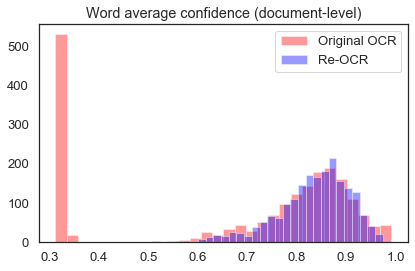

In [76]:
sns.distplot(df["word_level_average_confidence_ocr"].values, label="Original OCR", kde=False, color="red", bins=30)
sns.distplot(df["word_level_average_confidence_reocr"].values, label="Re-OCR", kde=False, color="blue", bins=30)
plt.title("Word average confidence (document-level)")
plt.legend()
plt.tight_layout()

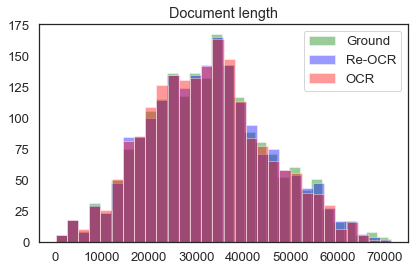

In [77]:
sns.distplot([len(x) for x in df["text_ground"].values], label="Ground", kde=False, color="green", bins=30)
sns.distplot([len(x) for x in df["text_reocr"].values], label="Re-OCR", kde=False, color="blue", bins=30)
sns.distplot([len(x) for x in df["text_ocr"].values], label="OCR", kde=False, color="red", bins=30)
plt.title("Document length")
plt.legend()
plt.tight_layout()

### Setup and pre-processing

In [78]:
!python -m spacy download nl


    Linking successful
    /anaconda3/envs/ocr_lm/lib/python3.7/site-packages/nl_core_news_sm -->
    /anaconda3/envs/ocr_lm/lib/python3.7/site-packages/spacy/data/nl

    You can now load the model via spacy.load('nl')



In [99]:
sample_size = 300

sample_ground = df["text_ground"].sample(n=sample_size, random_state=seed)
sample_ocr = df["text_ocr"].sample(n=sample_size, random_state=seed)

In [100]:
print(len(sample_ground))

300


In [101]:
sample_ground[:2]

1414    ['Woensdag', '28', 'juli', '1965', '48e', 'Jaa...
1750    ['Derde', 'waarschuwing', 'De', 'verhoging', '...
Name: text_ground, dtype: object

In [102]:
sample_ocr[:2]

1414    ['Woensdag', '28', 'juli', '1965', '48e', 'Jaa...
1750    ['Derde', 'waarschuwing', 'Tye', 'verhoging', ...
Name: text_ocr, dtype: object

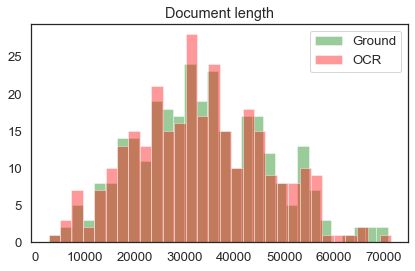

In [103]:
sns.distplot([len(x) for x in sample_ground], label="Ground", kde=False, color="green", bins=30)
sns.distplot([len(x) for x in sample_ocr], label="OCR", kde=False, color="red", bins=30)
plt.title("Document length")
plt.legend()
plt.tight_layout()

In [104]:
# trim, just to speed up experiments

LIMIT = 30000

sample_ground = [x[:LIMIT] for x in sample_ground]
sample_ocr = [x[:LIMIT] for x in sample_ocr]

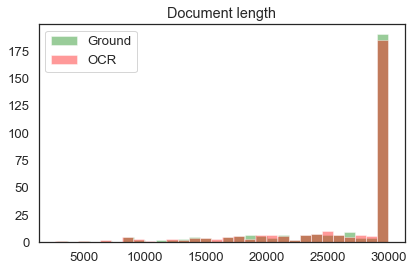

In [105]:
sns.distplot([len(x) for x in sample_ground], label="Ground", kde=False, color="green", bins=30)
sns.distplot([len(x) for x in sample_ocr], label="OCR", kde=False, color="red", bins=30)
plt.title("Document length")
plt.legend()
plt.tight_layout()

#### Pre-processing

* Remove stop-words
* Lemmatize
* Lowercase
* Remove tokens shorter than 3 characters
* Add frequent bigrams

*TODO: test without pre-processing.*

In [131]:
nlp = spacy.load('nl')
STOPWORDS = spacy.lang.nl.stop_words.STOP_WORDS
STOPWORDS.add("eene")

In [136]:
%%time

processed_docs = list()
for doc in nlp.pipe(sample_ocr, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    #ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token.lower() for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than one word.
    #doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)

CPU times: user 17min 40s, sys: 2min 58s, total: 20min 38s
Wall time: 7min 20s


In [137]:
docs = processed_docs
del processed_docs

# Add bigrams
from gensim.models.phrases import Phrases
# Add bigrams to docs (only ones that appear 20 times or more). A better approach would be to use a chi_sq test.
bigram = Phrases(docs, min_count=25)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [138]:
# CHANGE this
#docs_ground = docs
docs_ocr = docs

In [139]:
# save corpora
import pickle

with open('topic_modelling/docs_ground.pkl', 'wb') as handle:
    pickle.dump(docs_ground, handle)
with open('topic_modelling/docs_ocr.pkl', 'wb') as handle:
    pickle.dump(docs_ocr, handle)

#### Start from the pre-processed corpus

In [140]:
# load corpora
import pickle

docs_ground = list()
docs_ocr = list()

with open('topic_modelling/docs_ground.pkl', 'rb') as handle:
    docs_ground = pickle.load(handle)
with open('topic_modelling/docs_ocr.pkl', 'rb') as handle:
    docs_ocr = pickle.load(handle)

In [141]:
# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5

In [142]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary_ground = Dictionary(docs_ground)
dictionary_ground.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus_ground = [dictionary_ground.doc2bow(doc) for doc in docs_ground]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary_ground))
print('Number of docs: %d' % len(corpus_ground))

Number of unique tokens: 10574
Number of docs: 300


In [143]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary_ocr = Dictionary(docs_ocr)
dictionary_ocr.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus_ocr = [dictionary_ocr.doc2bow(doc) for doc in docs_ocr]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary_ocr))
print('Number of docs: %d' % len(corpus_ocr))

Number of unique tokens: 10361
Number of docs: 300


## LDA

In [144]:
%%time

from gensim.models import LdaMulticore, LdaModel
params = {'num_topics': 15,'passes': 1, 'random_state': seed}
model_ground = LdaModel(corpus=corpus_ground, num_topics=params['num_topics'], id2word=dictionary_ground, #workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 6.52 s, sys: 35 ms, total: 6.56 s
Wall time: 1.67 s


In [145]:
%%time

from gensim.models import LdaMulticore, LdaModel
params = {'num_topics': 15,'passes': 1, 'random_state': seed}
model_ocr = LdaModel(corpus=corpus_ocr, num_topics=params['num_topics'], id2word=dictionary_ocr, #workers=6,
                passes=params['passes'], random_state=params['random_state'])

CPU times: user 6.27 s, sys: 33.1 ms, total: 6.3 s
Wall time: 1.59 s


In [146]:
model_ground.show_topics(num_words=5)

[(2,
  '0.002*"den_heer" + 0.002*"april" + 0.002*"politie" + 0.001*"week" + 0.001*"regeering"'),
 (5,
  '0.002*"den_heer" + 0.002*"regeering" + 0.002*"commissie" + 0.001*"blad" + 0.001*"zijne"'),
 (9,
  '0.002*"regeering" + 0.002*"juli" + 0.001*"regering" + 0.001*"april" + 0.001*"zijne"'),
 (11,
  '0.002*"den_heer" + 0.002*"woord" + 0.001*"president" + 0.001*"zijne" + 0.001*"heeren"'),
 (3,
  '0.002*"den_heer" + 0.002*"politie" + 0.001*"regeering" + 0.001*"zegt" + 0.001*"regering"'),
 (12,
  '0.003*"den_heer" + 0.002*"politie" + 0.001*"raad" + 0.001*"maart" + 0.001*"volk"'),
 (7,
  '0.002*"den_heer" + 0.002*"regeering" + 0.002*"politie" + 0.002*"april" + 0.002*"mei"'),
 (0,
  '0.002*"den_heer" + 0.002*"volk" + 0.002*"politie" + 0.002*"regeering" + 0.001*"voorzitter"'),
 (6,
  '0.002*"vergadering" + 0.001*"den_heer" + 0.001*"president" + 0.001*"dienst" + 0.001*"regering"'),
 (4,
  '0.002*"den_heer" + 0.002*"gemeente" + 0.001*"regeering" + 0.001*"politie" + 0.001*"kinderen"')]

In [147]:
model_ocr.show_topics(num_words=5)

[(1,
  '0.002*"maart" + 0.002*"oorlog" + 0.002*"regering" + 0.001*"bet" + 0.001*"politie"'),
 (12,
  '0.002*"april" + 0.001*"staten" + 0.001*"vrouw" + 0.001*"bet" + 0.001*"regeering"'),
 (11,
  '0.002*"den_heer" + 0.002*"kamer" + 0.001*"politie" + 0.001*"woord" + 0.001*"wet"'),
 (14,
  '0.002*"den_heer" + 0.002*"eigen" + 0.001*"tusschen" + 0.001*"bet" + 0.001*"vergadering"'),
 (10,
  '0.002*"den_heer" + 0.002*"eigen" + 0.002*"mei" + 0.002*"woord" + 0.001*"tusschen"'),
 (2,
  '0.002*"regeering" + 0.001*"dienst" + 0.001*"stad" + 0.001*"artikel" + 0.001*"politie"'),
 (3,
  '0.002*"politie" + 0.002*"den_heer" + 0.001*"zaak" + 0.001*"regeering" + 0.001*"gemeente"'),
 (7,
  '0.002*"bet" + 0.002*"staten" + 0.002*"den_heer" + 0.002*"politie" + 0.002*"eigen"'),
 (13,
  '0.002*"april" + 0.002*"huis" + 0.002*"den_heer" + 0.002*"politie" + 0.001*"ned"'),
 (0,
  '0.001*"mei" + 0.001*"gemeente" + 0.001*"volk" + 0.001*"bet" + 0.001*"woord"')]

In [60]:
# plot topics (NOTE: the IDs here do not match those from the model)
data_ground =  pyLDAvis.gensim.prepare(model_ground, corpus_ground, dictionary_ground)
pyLDAvis.display(data_ground)

In [61]:
# plot topics
data_ocr =  pyLDAvis.gensim.prepare(model_ocr, corpus_ocr, dictionary_ocr)
pyLDAvis.display(data_ocr)

### Evaluation

#### Intrinsic eval

See http://qpleple.com/topic-coherence-to-evaluate-topic-models

In [148]:
# Compute Perplexity GROUND
print('\nPerplexity: ', model_ground.log_perplexity(corpus_ground))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model_ground, texts=docs_ground, dictionary=dictionary_ground, coherence='c_uci')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

coherence_model_lda = CoherenceModel(model=model_ground, texts=docs_ground, dictionary=dictionary_ground, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.675813444949428

Coherence Score:  -3.512192324279394

Coherence Score:  0.21961901932337577


In [149]:
# Compute Perplexity OCR
print('\nPerplexity: ', model_ocr.log_perplexity(corpus_ocr))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model_ocr, texts=docs_ground, dictionary=dictionary_ocr, coherence='c_uci')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

coherence_model_lda = CoherenceModel(model=model_ocr, texts=docs_ocr, dictionary=dictionary_ocr, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.69055664402583

Coherence Score:  -3.78769204206443

Coherence Score:  0.21767199174551824


#### Extrinsic

##### Match of topics

We match every topic in the OCR model with a topic in the human model (by best matching), and assess the overall distance between the two using the weighted total distance over a set of N top words (from the human model to the ocr model). The higher this value, the closest two topics are.

Note that to find a matching, we create a weighted network and find the maximal bipartite matching using NetworkX.

Afterwards, we can measure the distance of the best match, e.g., using the KL divergence (over the same set of words).

In [150]:
import networkx as nx

G = nx.Graph()

top_n = 500

# add bipartite nodes
G.add_nodes_from(['h_'+str(t_h[0]) for t_h in model_ground.show_topics(num_topics = -1, formatted=False, num_words=1)], bipartite=0)
G.add_nodes_from(['o_'+str(t_o[0]) for t_o in model_ocr.show_topics(num_topics = -1, formatted=False, num_words=1)], bipartite=1)

# add weighted edges
for t_h in model_ground.show_topics(num_topics = -1, formatted=False, num_words=top_n):
    for t_o in model_ocr.show_topics(num_topics = -1, formatted=False, num_words=top_n):
        # note that the higher the weight, the shorter the distance between the two distributions, so we do 1-weight to then do minimal matching
        words_of_h = [x[0] for x in t_h[1]]
        words_of_o = [x[0] for x in t_o[1]]
        weights_of_o = {x[0]:x[1] for x in t_o[1]}
        words_in_common = list(set(words_of_h).intersection(set(words_of_o)))
        # sum the weighted joint probability of every shared word in the two models
        avg_weight = 1 - sum([x[1]*weights_of_o[x[0]] for x in t_h[1] if x[0] in words_in_common])
        G.add_edge('h_'+str(t_h[0]),'o_'+str(t_o[0]),weight=avg_weight)
        G.add_edge('o_'+str(t_o[0]),'h_'+str(t_h[0]),weight=avg_weight)

In [151]:
len(G.edges())

225

In [152]:
nx.is_bipartite(G)

True

In [153]:
nx.is_connected(G)

True

In [154]:
bipartite_solution = nx.bipartite.matching.minimum_weight_full_matching(G)

In [155]:
from scipy.stats import entropy
from collections import defaultdict

# analyse matches

distances = list()
n_words_in_common = list()
matches = defaultdict(int)

for match_h,match_o in bipartite_solution.items():
    if match_h.startswith('o'): # to avoid repeating the matches (complete graph!)
        break
    matches[int(match_h.split("_")[1])] = int(match_o.split("_")[1])
    m_h = model_ground.show_topic(int(match_h.split("_")[1]), topn=top_n)
    m_o = model_ocr.show_topic(int(match_o.split("_")[1]), topn=top_n)
    weights_of_o = {x[0]:x[1] for x in m_o}
    words_of_h = [x[0] for x in m_h]
    words_of_o = [x[0] for x in m_o]
    words_in_common = list(set(words_of_h).intersection(set(words_of_o)))
    n_words_in_common.append(len(words_in_common)/top_n)
    dist_h = list()
    dist_o = list()
    for w in m_h:
        if w[0] in words_in_common:
            dist_h.append(w[1])
            dist_o.append(weights_of_o[w[0]])
    print("ground",match_h,model_ground.show_topic(int(match_h.split("_")[1])))
    print("OCR",match_o,model_ocr.show_topic(int(match_o.split("_")[1])))
    # normalize
    dist_h = dist_h/sum(dist_h)
    dist_o = dist_o/sum(dist_o)
    dist = entropy(dist_h,dist_o)
    distances.append(dist)
    print("KL divergence", dist)
    print("Words in common", len(words_in_common))
    print('=======')

ground h_13 [('den_heer', 0.0017830097), ('politie', 0.001546846), ('commissie', 0.0015184327), ('stad', 0.0014791134), ('april', 0.001475144), ('kamer', 0.0014509498), ('woord', 0.0012785691), ('partij', 0.001229982), ('heeren', 0.0012217225), ('oorlog', 0.0012157215)]
OCR o_7 [('bet', 0.0020251286), ('staten', 0.0016935283), ('den_heer', 0.0016531339), ('politie', 0.0015382643), ('eigen', 0.0015147051), ('mei', 0.0014518021), ('volk', 0.0014304671), ('raad', 0.0012745629), ('april', 0.0012551376), ('huis', 0.0012515694)]
KL divergence 0.029373478
Words in common 402
ground h_7 [('den_heer', 0.0016660558), ('regeering', 0.0016633153), ('politie', 0.0016222702), ('april', 0.0015956747), ('mei', 0.0015698755), ('rotterdam', 0.0013407038), ('gemeente', 0.0013280328), ('woord', 0.0012995397), ('kamer', 0.0012872937), ('door', 0.0012817555)]
OCR o_4 [('den_heer', 0.0016102955), ('gemeente', 0.0014844817), ('regeering', 0.001471651), ('kamer', 0.0013881484), ('zegt', 0.0013871706), ('mei', 

Text(0.5, 0, 'KL divergence between ground and OCR topics, with N=500.')

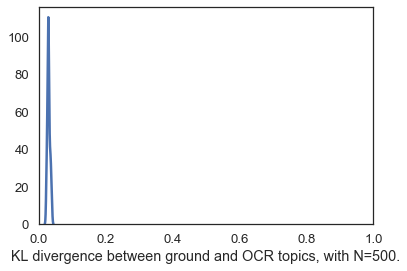

In [156]:
sns.distplot(distances, hist=False)
plt.xlim((0,1))
plt.xlabel("KL divergence between ground and OCR topics, with N=%d."%top_n)

Text(0.5, 0, 'Number of words in common between ground and OCR topics, with N=500.')

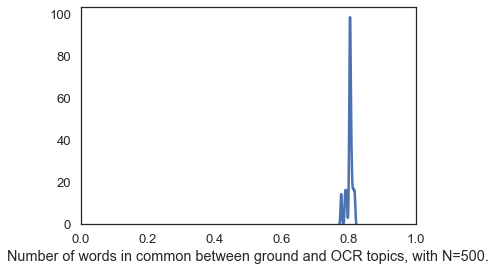

In [157]:
sns.distplot(n_words_in_common, hist=False)
plt.xlim((0,1))
plt.xlabel("Number of words in common between ground and OCR topics, with N=%d."%top_n)

#### Entropy

In [158]:
# this is how to access a document's topic distrbution

sorted(model_ground[corpus_ground[1]],key=lambda x:x[1],reverse=True)

[(3, 0.6541013),
 (10, 0.07838585),
 (4, 0.07622333),
 (1, 0.058198024),
 (11, 0.05183729),
 (2, 0.027616384),
 (12, 0.020805756),
 (9, 0.019002963),
 (0, 0.0112776095)]

In [159]:
# entropy

from scipy.stats import entropy
entropy([0.87271583, 0.12518865])

0.377647879051522

In [160]:
entropies_ground = list()
max_cluster_ground = list()
for d in corpus_ground:
    entropies_ground.append(entropy([x[1] for x in model_ground[d]]))
    max_cluster_ground.append(sorted(model_ground[d],key=lambda x:x[1],reverse=True)[0][0])
    
entropies_ocr = list()
max_cluster_ocr = list()
for d in corpus_ocr:
    entropies_ocr.append(entropy([x[1] for x in model_ocr[d]]))
    max_cluster_ocr.append(sorted(model_ocr[d],key=lambda x:x[1],reverse=True)[0][0])

Ks_2sampResult(statistic=0.1133333333333334, pvalue=0.03909416143761234)

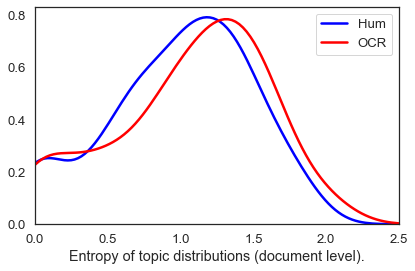

In [161]:
import seaborn as sns

sns.distplot(entropies_ground, hist=False, rug=False, label="Hum", color="blue")
sns.distplot(entropies_ocr, hist=False, rug=False, label="OCR", color="red")

plt.xlabel("Entropy of topic distributions (document level).")
plt.xlim((0,2.5))
plt.tight_layout()
#plt.savefig("figures/topic_modelling/Entropy_document_level_band_%d.pdf"%band)

from scipy.stats import ks_2samp, ttest_ind
ks_2samp(entropies_ground, entropies_ocr)

In [162]:
# Let's do the same for the topic distribution itself, considering the top N words

from collections import defaultdict

top_n_l = [500,1000,2000,5000]
entropies_ground_topics = defaultdict(list)
entropies_ocr_topics = defaultdict(list)

for tn in top_n_l:
    for t in model_ground.show_topics(num_topics=-1, formatted=False, num_words=tn):
        entropies_ground_topics[tn].append(entropy([x[1] for x in t[1]]))

    for t in model_ocr.show_topics(num_topics=-1, formatted=False, num_words=tn):
        entropies_ocr_topics[tn].append(entropy([x[1] for x in t[1]]))

Number of top n words: 500
Ks_2sampResult(statistic=0.26666666666666666, pvalue=0.5886144108520867)
Ttest_indResult(statistic=1.0338713399545192, pvalue=0.3100438182756761)
Number of top n words: 1000
Ks_2sampResult(statistic=0.3333333333333333, pvalue=0.30793528915875557)
Ttest_indResult(statistic=2.0734026271786807, pvalue=0.04744971752127454)
Number of top n words: 2000
Ks_2sampResult(statistic=0.4, pvalue=0.13586396446759655)
Ttest_indResult(statistic=3.1517188661408055, pvalue=0.0038464462506830853)
Number of top n words: 5000
Ks_2sampResult(statistic=0.4666666666666667, pvalue=0.05146730692911875)
Ttest_indResult(statistic=1.9721060396111885, pvalue=0.05854868092371881)


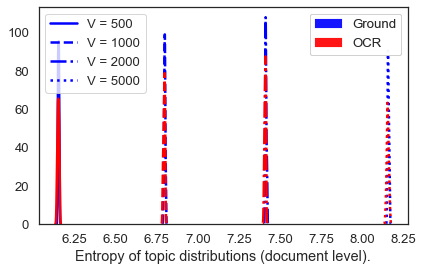

In [163]:
import matplotlib.patches as mpatches

line_styles = ['-', '--', '-.', ':']

for n,tn in enumerate(top_n_l):
    print("Number of top n words:",tn)
    sns.distplot(entropies_ground_topics[tn], hist=False, rug=False, label="V = %d"%tn, color="blue", kde_kws={'linestyle':line_styles[n]})
    sns.distplot(entropies_ocr_topics[tn], hist=False, rug=False, color="red", kde_kws={'linestyle':line_styles[n]})
    print(ks_2samp(entropies_ground_topics[tn], entropies_ocr_topics[tn]))
    print(ttest_ind(entropies_ground_topics[tn], entropies_ocr_topics[tn]))
    print("============")

legend1 = plt.legend(loc="upper left")
blue_patch = mpatches.Patch(color='blue', label='Ground', linestyle="-", linewidth=0.1, alpha=0.9)
red_patch = mpatches.Patch(color='red', label='OCR', linestyle="-", linewidth=0.1, alpha=0.9)
legend2 = plt.legend(handles=[blue_patch,red_patch], loc="upper right")
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.xlabel("Entropy of topic distributions (document level).")
#plt.xlim((5,8.5))
plt.tight_layout()
#plt.savefig("figures/topic_modelling/Entropy_topic_level_band_%d.pdf"%band)

#### Clustering by top topic

Create a histogram with the proportion of documents from the best match established as above

In [164]:
matches_per_cluster = defaultdict(int)
documents_per_cluster = defaultdict(int)

for h,o in zip(max_cluster_ground,max_cluster_ocr):
    documents_per_cluster[h] += 1
    if o == matches[h]:
        matches_per_cluster[h] += 1

In [165]:
matches_per_cluster

defaultdict(int, {0: 4, 7: 1, 4: 1, 3: 9, 1: 5, 8: 2, 9: 1, 12: 2, 2: 1})

In [166]:
documents_per_cluster

defaultdict(int,
            {4: 23,
             3: 115,
             0: 43,
             11: 18,
             1: 34,
             7: 12,
             10: 11,
             9: 4,
             8: 11,
             2: 3,
             6: 5,
             5: 4,
             13: 7,
             12: 8,
             14: 2})

In [167]:
clusters_proportions = [v/documents_per_cluster[k] for k,v in matches_per_cluster.items()]

clusters_proportions

[0.09302325581395349,
 0.08333333333333333,
 0.043478260869565216,
 0.0782608695652174,
 0.14705882352941177,
 0.18181818181818182,
 0.25,
 0.25,
 0.3333333333333333]

In [168]:
np.average(clusters_proportions)

0.1622562286958885

In [169]:
np.median(clusters_proportions)

0.14705882352941177

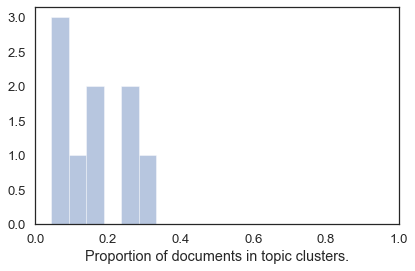

In [170]:
sns.distplot(clusters_proportions, norm_hist=False, bins=6, kde=False)
plt.xlabel("Proportion of documents in topic clusters.")
plt.xlim((0,1))
plt.tight_layout()
#plt.savefig("figures/topic_modelling/Docs_in_clusters_band_%d.pdf"%band)

#### Manual inspection of some documents for comparison

From: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

Find the most discriminative document per topic. For topic-topic matching, see above.

In [171]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords_ground = format_topics_sentences(ldamodel=model_ground, corpus=corpus_ground, texts=docs_ground)
df_topic_sents_keywords_ocr = format_topics_sentences(ldamodel=model_ocr, corpus=corpus_ocr, texts=docs_ocr)

# Format
df_dominant_topic_ground = df_topic_sents_keywords_ground.reset_index()
df_dominant_topic_ground.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_ocr = df_topic_sents_keywords_ocr.reset_index()
df_dominant_topic_ocr.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [173]:
# Show
df_dominant_topic_ground.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.3957,"den_heer, gemeente, regeering, politie, kinder...","[woensdag, juli, jaargang, abonnees, limburgs,..."
1,1,3.0,0.6784,"den_heer, politie, regeering, zegt, regering, ...","[derde, waarschuwing, verhoging, rente, nederl..."
2,2,0.0,0.9858,"den_heer, volk, politie, regeering, voorzitter...","[onderscheiden, gemakkelijk, volgen, biljetten..."
3,3,3.0,0.2847,"den_heer, politie, regeering, zegt, regering, ...","[jaargang, dinsdag, juli, twentsch, dagblad, t..."
4,4,0.0,0.6308,"den_heer, volk, politie, regeering, voorzitter...","[nieuwe, professor, van, school, laren, een, f..."
5,5,1.0,0.4286,"vrouw, idem, den_heer, april, politie, rotterd...","[ryestem, redakteur, uitgever, wilfred, lionar..."
6,6,7.0,0.8362,"den_heer, regeering, politie, april, mei, rott...","[den, dienst, suriname, bestemde, off, van, aa..."
7,7,10.0,0.5023,"regeering, den_heer, gemeente, raad, kamer, po...","[hoofdblad, friesland, sinds, woensdag, august..."
8,8,3.0,0.5169,"den_heer, politie, regeering, zegt, regering, ...","[non, combattanten, samen, gebracht, haar, ver..."
9,9,0.0,0.5923,"den_heer, volk, politie, regeering, voorzitter...","[eene, beknopte, schets, daden, welke, den, ne..."


In [174]:
# Show
df_dominant_topic_ocr.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.8911,"den_heer, tusschen, april, politie, regeering,...","[woensdag, juli, jaargang, abonnees, limburgs,..."
1,1,0.0,0.2393,"mei, gemeente, volk, bet, woord, den_heer, wat...","[derde, waarschuwing, tye, verhoging, rente, n..."
2,2,3.0,0.3197,"politie, den_heer, zaak, regeering, gemeente, ...","[ondiersdhipmen, mjjstien, apjfl, zijr, zeer, ..."
3,3,6.0,0.9448,"den_heer, tusschen, april, politie, regeering,...","[jïaarpairag, dtotag, jnll, ïwentsch, tubantia..."
4,4,6.0,0.4023,"den_heer, tusschen, april, politie, regeering,...","[nieuwe, professor, van, reesschool, laren, ee..."
5,5,10.0,0.5200,"den_heer, eigen, mei, woord, tusschen, preside...","[vrije, stem, ftodakteur, uitgever, wilfred, l..."
6,6,7.0,0.4694,"bet, staten, den_heer, politie, eigen, mei, vo...","[vóof, den, bariaaae, nde, off, tan, net, aals..."
7,7,1.0,0.7111,"maart, oorlog, regering, bet, politie, blad, v...","[hoofd, blad, friesland, sinds, ïffi, woknsdag..."
8,8,7.0,0.3173,"bet, staten, den_heer, politie, eigen, mei, vo...","[non, combattanten, samen, gebracht, haar, ver..."
9,9,1.0,0.7313,"maart, oorlog, regering, bet, politie, blad, v...","[eene, beknopte, schets, daden, welk, den, ned..."


In [175]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_ground = pd.DataFrame()

sent_topics_outdf_grpd_ground = df_topic_sents_keywords_ground.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_ground:
    sent_topics_sorteddf_ground = pd.concat([sent_topics_sorteddf_ground, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_ground.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_ground.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [177]:
# Show
sent_topics_sorteddf_ground

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9970,"den_heer, volk, politie, regeering, voorzitter...","[ting, zwaar, geſchut, beſchieten, deezen, avo..."
1,1.0,0.9939,"vrouw, idem, den_heer, april, politie, rotterd...","[onteigenen, geootte, volgnummer, grondplan, h..."
2,2.0,0.6746,"den_heer, april, politie, week, regeering, kin...","[een, request, schermvereeniging, alhier, houd..."
3,3.0,0.9992,"den_heer, politie, regeering, zegt, regering, ...","[nieuwe, amsterdamsche, courant, algemeen, han..."
4,4.0,0.9991,"den_heer, gemeente, regeering, politie, kinder...","[doorluchtige, vader, hasselt, leuven, hoofd, ..."
5,5.0,0.8299,"den_heer, regeering, commissie, blad, zijne, r...","[bekendma, kingen, raadsheer, swinderen, geden..."
6,6.0,0.9821,"vergadering, den_heer, president, dienst, rege...","[west, jaargaag, maandag, mei, nieuwsblad, uit..."
7,7.0,0.8450,"den_heer, regeering, politie, april, mei, rott...","[vriesche, courant, vrydag, den, van, lentemaa..."
8,8.0,0.9966,"artikel, dienst, mee, volk, regering, vergader...","[artikel, kosten, eind, examens, rijkszuivelsc..."
9,9.0,0.7344,"regeering, juli, regering, april, zijne, den_h...","[besprekingen, ten, paleize, herstel, twee, ee..."


In [178]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_ocr = pd.DataFrame()

sent_topics_outdf_grpd_ocr = df_topic_sents_keywords_ocr.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd_ocr:
    sent_topics_sorteddf_ocr = pd.concat([sent_topics_sorteddf_ocr, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_ocr.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_ocr.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [179]:
# Show
sent_topics_sorteddf_ocr

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9913,"mei, gemeente, volk, bet, woord, den_heer, wat...","[agent, nederland, drukkerij, uitgeverij, amst..."
1,1.0,0.9988,"maart, oorlog, regering, bet, politie, blad, v...","[bureaus, voor, redactie, administratie, wilhe..."
2,2.0,0.9966,"regeering, dienst, stad, artikel, politie, wee...","[artikel, kosten, eind, examens, rijkszuivelsc..."
3,3.0,0.9388,"politie, den_heer, zaak, regeering, gemeente, ...","[vaandel, reeds, lang, tooneelvereeniging, geh..."
4,4.0,0.9685,"den_heer, gemeente, regeering, kamer, zegt, me...","[den, geachten, spreker, gelderland, onderzoek..."
5,5.0,0.6788,"politie, bet, aan, regeering, president, frank...","[provinciale, oveeijsselsche, zwolsche, couran..."
6,6.0,0.9991,"den_heer, tusschen, april, politie, regeering,...","[provinciale, noorbbrabantsche, courant, febru..."
7,7.0,0.9888,"bet, staten, den_heer, politie, eigen, mei, vo...","[slaagde, vast, stellen, hiervan, oorzaak, leg..."
8,8.0,0.9941,"den_heer, maart, aan, zaak, dienst, tusschen, ...","[koetjepof, uit, moskou, verwijderd, hij, soes..."
9,9.0,0.9981,"politie, den_heer, tusschen, mei, kamer, zegt,...","[yen, leeningen, alle, buitengewone, heffing, ..."


### Number of topics

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics.
    From: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    params = {'passes': 3, 'random_state': seed}
    for num_topics in range(start, limit, step):
        m = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,# workers=6,
                passes=params['passes'], random_state=params['random_state'])
        model_list.append(m)
        coherencemodel = CoherenceModel(model=m, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run
limit=100; start=5; step=10;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_ground, corpus=corpus_ground, texts=docs_ground, start=start, limit=limit, step=step)

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Using Sklearn and NMF
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [49]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [50]:
# setup
n_samples = len(docs_ground)
n_features = 1000
n_components = 15
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [63]:
docs_ground[0]

['Woensdag',
 'juli',
 'Jaargang',
 'ABONNEES',
 'Limburgs',
 'Dagblad',
 'Directeur',
 'Drs',
 'Neerven',
 'Uitgave',
 'Mij',
 'Exploitatie',
 'Limburgs',
 'Dagblad',
 'Abonnementsprijs',
 'per',
 'kwartaal',
 'exclusief',
 'incassokosten',
 'per',
 'maand',
 'per',
 'week',
 'Amerikaanse',
 'jagers',
 'neergeschoten',
 'twee',
 'gebombardeerde',
 'lanceerterrei',
 'nen',
 'luchtdoelraketten',
 'werden',
 'schreven',
 'bases',
 'semi',
 'mobiele',
 'stallaties',
 'Zij',
 'gelegen',
 'ten',
 'noordwesten',
 'hoofdstad',
 'Hanoi',
 'behoren',
 'vijf',
 'eerder',
 'Pentagon',
 'gesignaleerde',
 'bases',
 'Het',
 'bom',
 'bardement',
 'volgde',
 'neerhalen',
 'afgelopen',
 'weekeinde',
 'Amerikaans',
 'vliegtuig',
 'ongeveer',
 'Hanoi',
 'meende',
 'Sam',
 'lucht',
 'doelraket',
 'Russische',
 'makelij',
 'eer',
 'ste',
 'Amerikaanse',
 'toestellen',
 'gebruikt',
 'Onderminister',
 'Defensie',
 'Arthur',
 'Syl',
 'vester',
 'deelde',
 'mee',
 'aanval',
 'ringe',
 'hoogte',
 'uitgevoerd',


In [65]:
def dummy(doc):
    """We use this to use the same tonekization and pre-processing we already did"""
    return doc

# Get tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer_g = TfidfVectorizer(max_features=n_features, lowercase=False, tokenizer=dummy, preprocessor=dummy)
tfidf_vectorizer_o = TfidfVectorizer(max_features=n_features, lowercase=False, tokenizer=dummy, preprocessor=dummy)
t0 = time()
tfidf_g = tfidf_vectorizer_g.fit_transform(docs_ground)
tfidf_o = tfidf_vectorizer_o.fit_transform(docs_ocr)
print("done in %0.3fs." % (time() - t0))

# Get tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer_g = CountVectorizer(max_features=n_features, lowercase=False, tokenizer=dummy, preprocessor=dummy)
tf_vectorizer_o = CountVectorizer(max_features=n_features, lowercase=False, tokenizer=dummy, preprocessor=dummy)
t0 = time()
tf_g = tf_vectorizer_g.fit_transform(docs_ground)
tf_o = tf_vectorizer_o.fit_transform(docs_ocr)
print("done in %0.3fs." % (time() - t0))
print()

Extracting tf-idf features for NMF...
done in 0.519s.
Extracting tf features for LDA...
done in 0.366s.



In [66]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

t0 = time()
nmf_g_fr = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_g)
nmf_o_fr = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf_o)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model GROUND (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer_g.get_feature_names()
print_top_words(nmf_g_fr, tfidf_feature_names, n_top_words)
print("\nTopics in NMF model OCR (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer_o.get_feature_names()
print_top_words(nmf_o_fr, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=100 and n_features=1000...
done in 0.150s.

Topics in NMF model GROUND (Frobenius norm):
Topic #0: den heer Het eene zoo wordt ten onder welke den_heer ter groote ver zullen zijne plaats thans zeer Een dezer
Topic #1: Het regering Amerikaanse grote wordt tussen Van Nederlandse Franse Van_onze ver jaar onze minister uur weer president waar ten nieuwe
Topic #2: Nws Journaal muz VPRO Gram programma film vandaag uur Afrika donderdag lezing woord Hier Voor kerk deel deur dag dezer_dagen
Topic #3: regeering Duitsche Duitschland Fransche Tsjecho den Italië Duitsch Frankrijk Italiaansche Spanje oorlog Polen minister Reuter Berlijn tusschen zouden commissie Europa
Topic #4: lett Amsterdam Een VAN Heer vrouw gevraagd eene gij net Huis zoo Maar vraagt zijne aangeboden hare prijs jaar DER
Topic #5: Keizer den_Keizer Hof den zyn Prins uwe Groot eene avonds geluk gehad des ontvangen eer dezelfde dezer dezer_dagen dien deur
Topic 

In [67]:
# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()

nmf_g_kl = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf_g)
nmf_o_kl = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf_o)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model GROUND (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer_g.get_feature_names()
print_top_words(nmf_g_kl, tfidf_feature_names, n_top_words)
print("\nTopics in NMF model OCR (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer_o.get_feature_names()
print_top_words(nmf_o_kl, tfidf_feature_names, n_top_words)

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=100 and n_features=1000...
done in 2.315s.

Topics in NMF model GROUND (generalized Kullback-Leibler divergence):
Topic #0: den zullen werden alle ver welke thans waar blijkt dagen zaak zoo waarin plaats Bij twee Ook volgende heer wor_den
Topic #1: één Amerikaanse zoals Dit zullen grote enige tussen wordt gen drie zouden Van Deze Hij Franse Europa waar land Het
Topic #2: zien zulk beter woord Ter zon zorgen aangeboden vol kwam hunne waarin Die dames volgende vader zes bovendien onder even
Topic #3: bestaat blijven vrede betrokken politiek terug recht werden bieden bestaan Britsche pers schepen Duitschland militaire officieel buitenlandsche troepen nieuwe Londen
Topic #4: weer brengen Maar vrouw gezegd naam daardoor bekend Het moest weinig tijd blijven geheel weg boven volkomen elke Daar opnieuw
Topic #5: één zullen zes zeven zyn beide alle dagen twee Den dier nieuwe den plaats Groningen Koni

In [69]:
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

t0 = time()
lda_g = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda_g.fit(tf_g)
lda_o = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda_o.fit(tf_o)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model GROUND:")
tf_feature_names = tf_vectorizer_g.get_feature_names()
print_top_words(lda_g, tf_feature_names, n_top_words)
print("\nTopics in LDA model OCR:")
tf_feature_names = tf_vectorizer_o.get_feature_names()
print_top_words(lda_o, tf_feature_names, n_top_words)

Fitting LDA models with tf features, n_samples=100 and n_features=1000...
done in 1.339s.

Topics in LDA model GROUND:
Topic #0: Het Juli weer Huis pCt per grote ten wordt Nederlandse gaan Israël waar Aug den week moeten premier zaken uur
Topic #1: Het wordt Amerikaanse Waardenburg geheel weer president Israël minister drie Hij tussen aantal ver zullen ter Van land gezegd weg
Topic #2: Het ver wordt land den Indonesische kringen ter eerste heel auto werden nationaal Hij zeer ste twee tussen Staten zitting
Topic #3: geheel Waardenburg den water Willem huis Van wordt Hans onder weg Het Staat Een ver bekend alle Jan zullen Van_onze
Topic #4: den Het heer ten ver wordt onder uur zullen waar tijd Van dagen Een twee ter eerste jaar werden den_heer
Topic #5: den mej Artikel ten Het onder wordt ver ter heer behoeve alle ten_behoeve kosten Nederland volk welke tijd Juli uitgaven
Topic #6: gehad onze Februari publiek grote ring Nederland ander genoemd invloed woorden Maar stelde zullen plaatsen 